In [1]:
# Project
# Sugandhi Akula
# Rushya Puttam

Installing **pySpark** 

In [2]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 67kB/s 
     |████████████████████████████████| 204kB 43.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=9cf0167b2a02db2a0e2ed77b73600b8e3cbafb44918e42f99782e2d73a8ff219
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


**Importing necessary libraries**

In [3]:
import sys
from pyspark import SparkContext, SparkConf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
sc = SparkContext("local","PySpark k-means clustering")

In [5]:
# 4601 rows and 58 columns
file = '/content/drive/XXXXXXXXXXX/Project 3/data.txt'

In [6]:
fileRDD = sc.textFile(file,minPartitions=20)

In [7]:
#Assigning a row number to each row in the data and converting the values into float and then into an array
# key is the row number starting from 0, value is the float values of the given datapoints in an array
fileRDD=fileRDD.zipWithIndex().map(lambda x:(x[1],np.array([float(y) for y in x[0].split()])))

**Generating initial 10 cluster centres**

In [8]:
# Function:To assign nearest cluster to each data point
# This is a step in geenrating initial centroids : 10
# Function parameters
# 1. x:Each line of RDD
# Function returns : 
  #temp is clusterid-obs number
  #dist-distance from the datapoint to its nearest cluster
  #x[0] is obs number
  #x[1] is coordinates 
def clust_assn(x):
  temp=0
  dist=np.inf
  # Looping through all generated cluster centroids and assigning the nearest cluster centroid to each data point
  for i in clus_bd.value:
    d = np.square(np.sqrt(sum(np.square(np.subtract(x[1], i[1])))))
    if d < dist:
      dist = d
      temp=i[0]
  return (temp,(dist,x[0],x[1]))

In [9]:
# Function to generate the initial 10 cluster centroids by checking for the farthest datapoints from all available centroids
# Function parameters: 
# 1. k- Number of centroids required
def generate_initial_centroids(k):
  #Getting first centroid
  #Picking a random row number
  first_centroid=random.sample(range(fileRDD.count()),1)
  #Getting the coordinates
  first_centroid_cord=fileRDD.filter(lambda x:x[0] in first_centroid)
  #Broadcasting 
  global clus_bd
  clus_bd=sc.broadcast(first_centroid_cord.collect())
  for i in range(k-1):
    l = []
    bla=fileRDD.map(lambda x:clust_assn(x))
    next_full = bla.max(key=lambda x: x[1][0]) #Finding the point with max distance
    next = (next_full[1][1], next_full[1][2])
    clus_bd.value.append(next)
    l = clus_bd.value
    clus_bd.unpersist()
    clus_bd = sc.broadcast(l)
    first_centroid.append(next[0])

**Calculating Euclidean, Manhattan and cost functions**

In [10]:
# Function to calculate the euclidean distance and assignment of datapoint to the cluster with least distance. 
# Function parameters:
# 1. x: Each line of the RDD
# 2. n : Number of clusters
# Function returns : 
  #temp is clusterid-obs number
  #x[0] is obs number
  #x[1] is coordinates 
  #cost - cost function value for the datapoint
def euc_distance_assign_cluster(x,n):
  temp=0
  dist=np.inf
  for i in range(n):
    d = np.sqrt(sum(np.square(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    if d < dist:
      dist = d
      temp=centroid_centres_bd.value[i][0]
      costf=dist**2
  return (temp,(x[0],x[1],costf))

In [11]:
# Function to calculate the Manhattan distance and assignment of datapoint to the cluster with least distance. 
# Function parameters:
# 1. x: Each line of the RDD
# 2. n : Number of clusters
# Function returns : 
  # temp is clusterid-obs number
  # x[0] is obs number
  # x[1] is coordinates 
  #cost - cost function value for the datapoint
def man_distance_assign_cluster(x,n):
  temp=0
  dist=np.inf
  for i in range(n):
    d = np.sqrt(sum(np.absolute(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    if d < dist:
      dist = d
      temp=centroid_centres_bd.value[i][0]
      cost=dist**2
  return (temp,(x[0],x[1],cost))

**Kmeans++ Algorithm**

In [12]:
# 20 iterations with 10 cluster loop
# Function to run Kmeans++ algorithm
# Function parameters: 
# 1. method = "e" for euclidean or "m" for  manhattan
# 2. n_clus = Number of cluster :10
# 3. n_iter = Number of iterations: 20
# Function returns: List of cost function values for each iteration
def kmeansplus(method, n_clus, n_iter):
  generate_initial_centroids(n_clus)
  cf=[]
  method = method.lower()
  global centroid_centres_bd
  centroid_centres_bd=sc.broadcast(clus_bd.value)
  for i in range(n_iter):
    if method == 'e':
      assign_cluster=fileRDD.map(lambda x: euc_distance_assign_cluster(x,n_clus))
    elif method == 'm':
      assign_cluster=fileRDD.map(lambda x: man_distance_assign_cluster(x,n_clus))
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    centroid_centres_bd.unpersist()
    centroid_centres_bd=sc.broadcast(new_clusters.collect())  
  #Now, assign_cluster has 4601 observations and its correspoding cluster number after 20 iterations
  return cf

In [16]:
costs_eu = kmeansplus('e', 10, 20)
kmpp_centroids_eu=[x[1] for x in centroid_centres_bd.value]
costs_man = kmeansplus('m', 10, 20)
kmpp_centroids_man=[x[1] for x in centroid_centres_bd.value]

In [17]:
# Cost function for iteration 20 with Euclidean distance
costs_eu[19]

90170771.49

In [18]:
# Cost function for iteration 20 with Manhattan distance
costs_man[19]

677345.74

**Saving the final cluster centres into a text file**

In [19]:
with open('/content/drive/XXXXXXXXXXXXXXX/kmeans++_centriods_eu.txt', "w") as output:
    output.write(str(kmpp_centroids_eu))

In [20]:
with open('/content/driveXXXXXXXXXXXXXXXXXXXXX/kmeans++_centriods_man.txt', "w") as output:
    output.write(str(kmpp_centroids_man))

**Plotting cost functions**

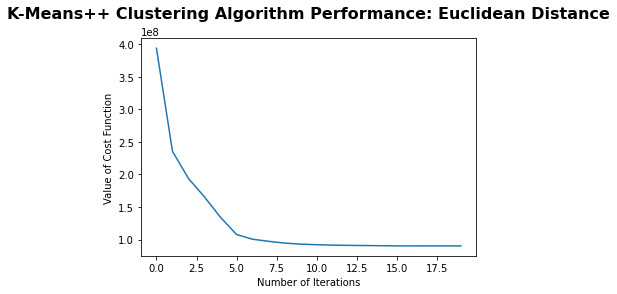

In [21]:
plt.xlabel('Number of Iterations')
plt.ylabel('Value of Cost Function')
plt.title('K-Means++ Clustering Algorithm Performance: Euclidean Distance',pad=20,fontsize=16, fontweight='bold')
plt.plot(range(20),costs_eu)

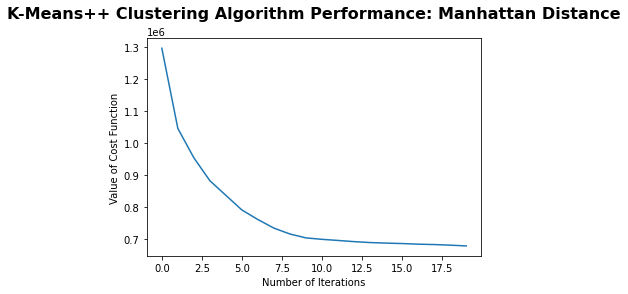

In [22]:
plt.xlabel('Number of Iterations')
plt.ylabel('Value of Cost Function')
#plt.suptitle('Cost function Φ vs Number of iterations', fontsize=8)
plt.title('K-Means++ Clustering Algorithm Performance: Manhattan Distance',pad=20, fontsize=16, fontweight='bold')
plt.plot(range(20),costs_man)

Text(0.5, 1.0, 'Comparision of Euclidean and Manhattan distance cost functions for Kmeans++ fucntion')

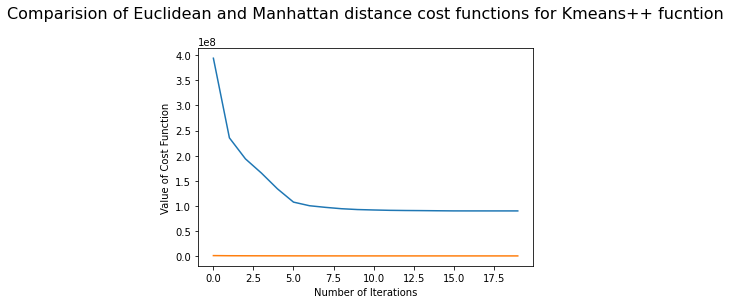

In [23]:
df = pd.DataFrame({"Iterations":range(20), "costs_eu":costs_eu, "costs_man":costs_man})
plt.plot(df["Iterations"], df["costs_eu"])
plt.plot(df["Iterations"], df["costs_man"])
plt.xlabel('Number of Iterations')
plt.ylabel('Value of Cost Function')
plt.title("Comparision of Euclidean and Manhattan distance cost functions for Kmeans++ fucntion", fontsize=16,pad=30)

**Calculating % change of cost functions after 10 iterations**

**#Reasoning**

As the number of iterations increase, the cost function value tends to fall. The same trend is observed for both euclidean and Manhattan distance cost functions. However, when the cost function is compared for euclidean and manhattan distances, manahattan has lower cost function values than euclidean. This is because while using the euclidean distance, we are able to achieve a greater decrease in the cost function over the first few iterations when compared to using the Manhattan distance.That being said, at the end of 20 iterations, the value of cost function is lower when Manhattan distances are employed than when euclidean distances are employed

In [24]:
per_chan_e=round(((costs_eu[0]-costs_eu[9])/costs_eu[0])*100,2)
print("Percentage Change of Cost fucntion after 10 iterations for Euclidean Φ: " + str(per_chan_e))

Percentage Change of Cost fucntion after 10 iterations for Euclidean Φ: 76.41


In [25]:
per_chan_m=round(((costs_man[0]-costs_man[9])/costs_man[0])*100,2)
print("Percentage Change of Cost fucntion after 10 iterations for Manhattan Ψ: " + str(per_chan_m))

Percentage Change of Cost fucntion after 10 iterations for Manhattan Ψ: 45.79


# Comparision of kmeans and kmeans++

For comparing these two algorithms, the cost fucntion vs number of iterations plots are observed for both euclidean and manhattan distances. For kmeans, the starting point of cost fucntion  is lower than the kmeans++. But, the end point value of cost function is higher than the kmeans++. This indicates for kmeans++ although it starts off at a higher cost function, convergence is achieved soon with smallest value of cost function compared to kmeans. This proves that kmeans++ may be the most efficient clustering algorithm of the two.